In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from src.utils.general import get_db_conn, get_boto3_session, load_model_s3, load_matrix_s3
from src.utils import project_constants as constants

In [4]:
from src.bill_passage.score_calibration_functions import get_passage_prob_model_score_buckets

In [5]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file)

In [6]:
exp_hash = 'aa36a41222408534233ebd20b7adca54'
model_group = 375

In [31]:
q = """
    select 
        model_id,
        train_end_time,
        to_char(train_end_time, 'YYYY-MM-DD') as train_end_time_str
    from triage_metadata.experiment_models
        join triage_metadata.models using(model_hash) 
    where experiment_hash='{exp_hash}'
    and model_group_id={model_group}
    order by train_end_time
""".format(
    exp_hash=exp_hash,
    model_group=model_group
)

models = pd.read_sql(q, db_conn)

In [25]:
buckets = {
    'will_not_pass': [0, 0.10],
    'unlikely': [0.10, 0.35],
    'could go either way': [0.35, 0.55],
    'likely': [0.55, 0.70],
    'very_likely': [0.70, 0.90],
    'will_pass': [0.90, 1.1]
}

#### Models

In [32]:
time_block = 1
model_id = models.at[time_block, 'model_id']
train_end_time = models.at[time_block, 'train_end_time']

In [33]:
q = """
    select 
        bill_id,
        bill_number,
        state,
        introduced_date,
        as_of_date,
        score,
        label_value
    from clean_2.bills a join test_results.predictions b on a.bill_id=b.entity_id
    where model_id={} and state='VT'
    order by score desc
    """.format(model_id)
vt_predictions = pd.read_sql(q, db_conn)

In [34]:
vt_predictions

,bill_id,bill_number,state,introduced_date,as_of_date,score,label_value
0,515802,H0377,VT,2013-02-26,2013-04-30,0.81264,1
1,541518,H0533,VT,2013-04-02,2013-04-30,0.81222,1
2,484999,H0105,VT,2013-01-29,2013-04-30,0.79933,1
3,539059,H0529,VT,2013-03-26,2013-04-30,0.79911,1
4,452437,S0030,VT,2013-01-15,2013-04-02,0.79867,1
...,...,...,...,...,...,...,...
6306,515949,S0139,VT,2013-02-26,2013-04-23,0.02219,0
6307,515813,H0379,VT,2013-02-26,2013-04-23,0.02123,0
6308,494209,H0251,VT,2013-02-12,2013-04-09,0.02082,0
6309,515818,H0380,VT,2013-02-26,2013-04-23,0.02029,0


In [35]:
q = """
    select 
        model_id,
        (sum(label_value)::float/count(*)) * 100 as passage_probability,
        count(*) as num_instances
    from clean_2.bills a join test_results.predictions b on a.bill_id=b.entity_id
    where model_id in {model_ids}
    and score >= {lower_lim_bucket}
    and score < {upper_lim_bucket}
    and state='VT'
    group by 1
"""

bucket_probabilities = pd.DataFrame()
for b, lim in buckets.items():    
    df = pd.read_sql(
        q.format(
            model_ids=tuple(models['model_id'].tolist()),
            lower_lim_bucket=lim[0],
            upper_lim_bucket=lim[1]
        ),
        db_conn
    )
    df['bucket_label'] = b
    df['lower_lim'] = lim[0]
    df['upper_lim'] = lim[1]
    
    bucket_probabilities = bucket_probabilities.append(df)
    

In [36]:
bucket_probabilities = bucket_probabilities.merge(models, on='model_id')

In [56]:
bucket_probabilities

,model_id,passage_probability,num_instances,bucket_label,lower_lim,upper_lim,train_end_time,train_end_time_str
0,11773,4.219409,3081,will_not_pass,0.00,0.10,2013-01-01,2013-01-01
1,11773,10.268841,2269,unlikely,0.10,0.35,2013-01-01,2013-01-01
2,11773,67.924528,477,could go either way,0.35,0.55,2013-01-01,2013-01-01
3,11773,81.250000,320,likely,0.55,0.70,2013-01-01,2013-01-01
4,11773,84.756098,164,very_likely,0.70,0.90,2013-01-01,2013-01-01
5,11775,0.000000,1,will_not_pass,0.00,0.10,2014-01-01,2014-01-01
6,11775,9.638554,83,unlikely,0.10,0.35,2014-01-01,2014-01-01
7,11775,74.000000,200,could go either way,0.35,0.55,2014-01-01,2014-01-01
8,11775,81.651376,109,likely,0.55,0.70,2014-01-01,2014-01-01
9,11775,91.891892,37,very_likely,0.70,0.90,2014-01-01,2014-01-01


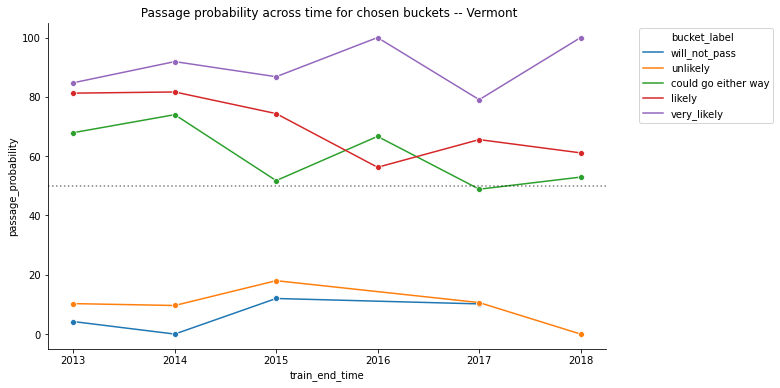

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))

g = sns.lineplot(
    data=bucket_probabilities,
    x='train_end_time',
    y='passage_probability',
    hue='bucket_label',
    marker='o',
    ax=ax
)
# g.set_xticklabels(labels=bucket_probabilities['train_end_time'].unique(), rotation=90)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.axhline(y=50, color='k', linestyle=':', alpha=0.5)
# t = ax.set_title(' Passage probability across time for chosen buckets \n (lower limit inclusive) \n \n {} \n'.format(buckets))
t = ax.set_title(' Passage probability across time for chosen buckets -- Vermont')

In [57]:
q = """
    with preds as (
        select 
            model_id, sum(label_value) as num_ones
        from clean_2.bills a join test_results.predictions b on a.bill_id=b.entity_id
        where model_id in {model_ids} and state='VT'
        group by 1
    )
    select 
        model_id,
        max(num_ones) as num_ones,
        sum(label_value)::float / max(num_ones) as bucket_recall,
        count(*) as num_instances
    from clean_2.bills a join test_results.predictions b on a.bill_id=b.entity_id join preds using(model_id)
    where model_id in {model_ids}
    and score >= {lower_lim_bucket}
    and score < {upper_lim_bucket}
    and state='VT'
    group by 1
"""

bucket_recall = pd.DataFrame()

for b, lim in buckets.items():    
    df = pd.read_sql(
        q.format(
            model_ids=tuple(models['model_id'].tolist()),
            lower_lim_bucket=lim[0],
            upper_lim_bucket=lim[1]
        ),
        db_conn
    )
    df['bucket_label'] = b
    df['lower_lim'] = lim[0]
    df['upper_lim'] = lim[1]
    
    bucket_recall = bucket_recall.append(df, ignore_index=True)

In [55]:
msk = bucket_recall['model_id'] == 11773 
bucket_recall[msk]['num_instances']

0     3081
4     2269
9      477
15     320
21     164
Name: num_instances, dtype: object

In [60]:
bucket_recall = bucket_recall.merge(models, on='model_id')

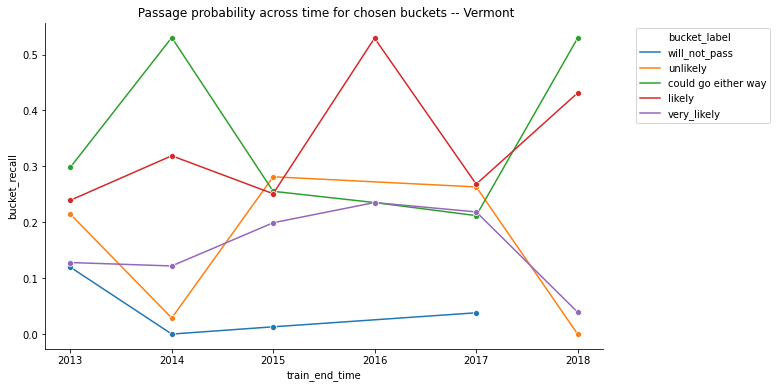

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))

g = sns.lineplot(
    data=bucket_recall,
    x='train_end_time',
    y='bucket_recall',
    hue='bucket_label',
    marker='o',
    ax=ax
)
# g.set_xticklabels(labels=bucket_probabilities['train_end_time'].unique(), rotation=90)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1))
# plt.axhline(y=50, color='k', linestyle=':', alpha=0.5)
# t = ax.set_title(' Passage probability across time for chosen buckets \n (lower limit inclusive) \n \n {} \n'.format(buckets))
t = ax.set_title(' Passage probability across time for chosen buckets -- Vermont')